# Autoregressive Model

This is an exploration of interpolating/predicting an autoregrissive model on a time series.  I took the algorithm from Numerical Recipes, 13.5 (Linear Prediction).  I will also compare it with python packages for AR models, such as `statsmodels`.

The basic idea is that we optimize coefficients of previous values in the time series to best predict a new value:

$$
y_t = \sum_{n=0}^{t-1} \beta_n y_n.
$$

Numerical recipes actually uses the autocorrelation function (ACF) $\phi(\tau)$ as the predictors:

$$
\phi_0 = \sum_{n=1}^{\tau} \theta_n \phi_n
$$

where $\tau$ is a given lag.  This means that I've implicitly changed the index from running forward in time overall indices to running backwards in time to some maximum lag $\tau$.  In the former case, we'd expect $\beta_n$ to be zero of $y_t$ had no memery (no correlation) with $y_n$.  In the latter case, we can achieve the same effect by letting $\tau$ go to infinitity and assuming the $\theta_n$ for large lags. In practice the number of previous datapoitns/lag time is a hyperparameter.

The unweighted, linear least squares $\chi^2$ is

$$
\chi^2 = \sum_{i=0}^{N} \left(\phi_i - \sum_{n=i -1}^{i - \tau}\beta_n\phi_n \right)^2.
$$

Differentiating with respect to the $\beta_n$, we get

$$
\boldsymbol{\beta} = X^{-1} \boldsymbol{\rho}
$$
where
$$
\rho_n = \sum_i\phi_{i}\phi_{i-j} 
$$
and
$$
X_{ij} = \sum_n \phi_{n-i}\phi_{n-j}.
$$

Convolutions (based on `numpy`/`scipy` appear to be efficient ways of calculating the model.  Note, however, that data points near the begining are spoiled, because there aren't samples as sufficiently long lags.

Below, I generate some fake data and fit for $\beta$.  gen_lc evaluates a random realization of a damped random walk, with a damping parameter equal to the numerical value entered.

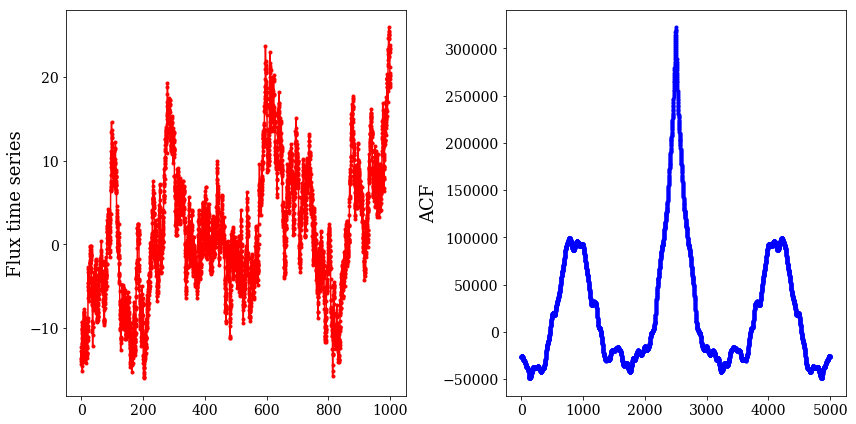

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 12,6
sp.random.seed(111111)

t = sp.r_[0:1000:5000j]
f = gen_lc(t,30)*8 #damped random walk, with an amplitude of 3 units
s = 2.0*sp.sin(2*sp.pi*1/15) #add a sign wave
noise = 0.2*sp.randn(len(f)) #can add white noise, if desired
f = f + s + noise
acf = sp.correlate(f,f,'same')

F,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(t,f,'r.-')
ax2.plot(acf,'b.-')

ax1.set_ylabel('Flux time series')
ax2.set_ylabel('ACF')

F.tight_layout()
#F.set_size_inches(12,6)

In [2]:
#def the function to fill and solve the design matrix
from scipy import linalg
def fit_coeffs(acf,N_memory):
    acf_roll = []
    for n in range(N_memory):
        acf_tmp = sp.roll(acf, -(n+1))
        #to avoid wrap around, set the end of the lagged acf to zero
        acf_tmp[-(n+1):] = 0
        acf_roll.append(acf_tmp)
        
    acf_roll = sp.array(acf_roll)
    
    #fill in the design matrices
    #len(acf)x1 matrix
    C = []
    for ii in range(len(acf_roll)):
        C.append(sp.sum(acf*acf_roll[ii]))
    C = sp.array(C)

    #len(acf)xN_memory matrix
    A = []
    for ii in range(len(acf_roll)):
        row = []
        for jj in range(len(acf_roll)):
            row.append(sp.sum(acf_roll[ii]*acf_roll[jj]))
        A.append(row)
    A = sp.array(A)


    return linalg.solve(A,C)

N_memory = 631
B = fit_coeffs(acf,N_memory)

`B` now has the coefficents, in order of increasing lag.  To predict, we must now convolve `B` with the time series, which reverses the times correctly.  Also note that the first `N_memory -1` elements do not have enough lagged measurements and are thereofre unreliable.  

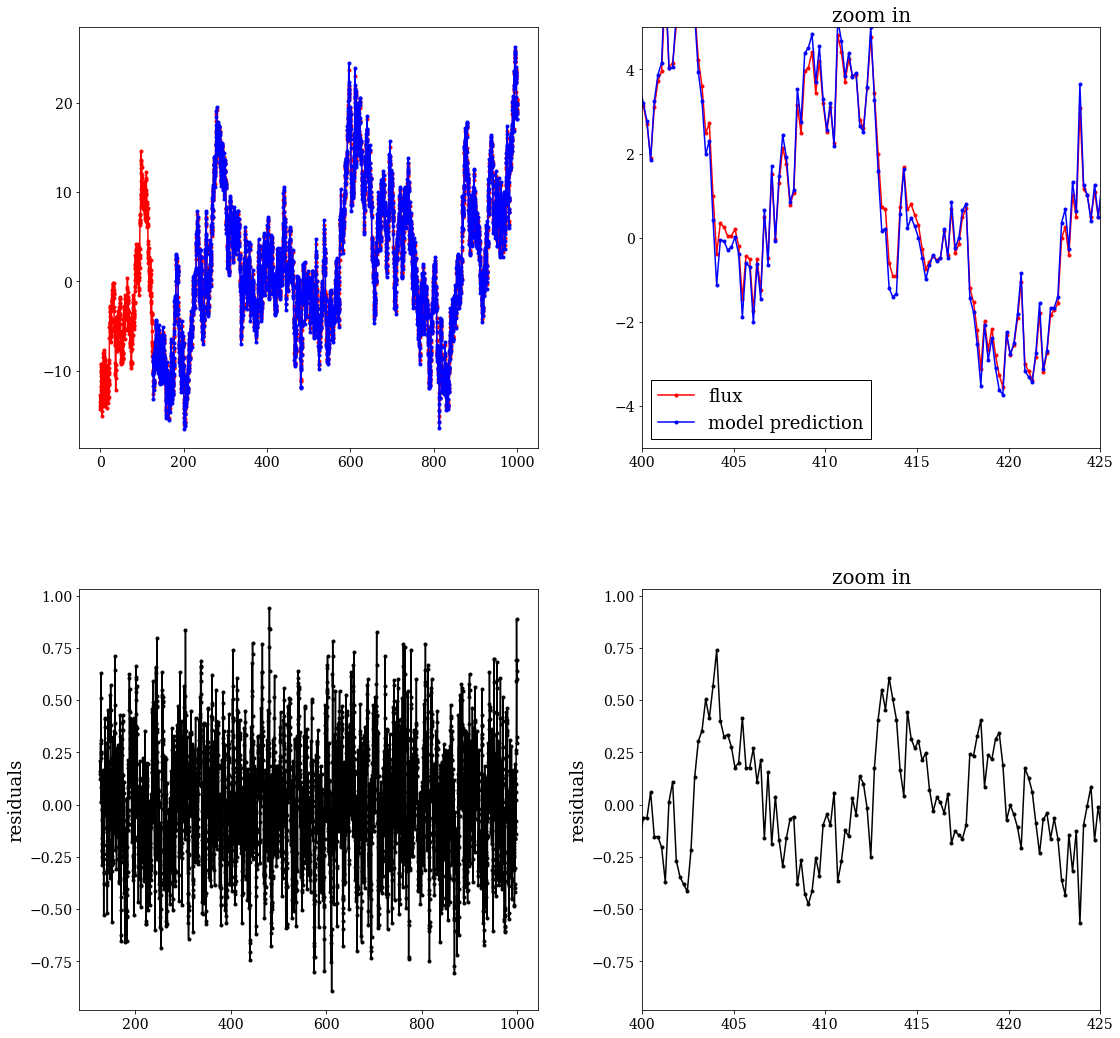

In [3]:
#note that the 
pred = sp.convolve(f,B,'valid')


F,( (ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
ax1.plot(t,f,'r.-')
#ax1.plot(t[0:-N_memory//2] + (N_memory/2- 1)*(t[1] - t[0]),pred[0:-N_memory//2],'b.-',zorder=2)
ax1.plot(t[N_memory - 1::], pred,'b.-',zorder=2)

#zoom in 
ax2.plot(t,f,'r.-',label='flux')
#ax2.plot(t[0:-N_memory//2] + (N_memory/2- 1)*(t[1] - t[0]),pred[0:-N_memory//2],'b.-',zorder=2)
ax2.plot(t[N_memory-1:], pred,'b.-',zorder=2,label='model prediction')
ax2.set_xlim([400,425])
ax2.set_ylim([-5,5])

ax2.legend()
#residuals
res = f[N_memory-1::] - pred

ax3.plot(t[N_memory - 1::], res,'k.-')
ax3.set_ylabel('residual')
ax4.plot(t[N_memory - 1::], res,'k.-')
ax4.set_xlim([400,425])
#ax4.set_ylim([-5,5])
ax4.set_ylabel('residual')

ax2.set_title('zoom in')
ax3.set_ylabel('residuals')
ax4.set_title('zoom in')
ax4.set_ylabel('residuals')

F.tight_layout()
F.set_size_inches(16,16)

The residuls are obviously correlated.  However, the distribution of residuals is remarkably similar to white noise.  Unfortunately, it does not correlate with the input noise, nor does it have the same amplitude  

[-3.68112063e-02  1.03133893e+00  2.62821929e+02]
0.27618638506117277 0.20007910118694613


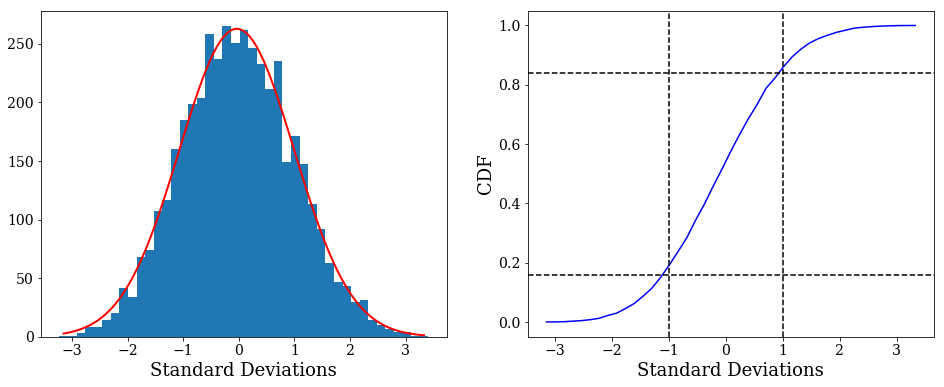

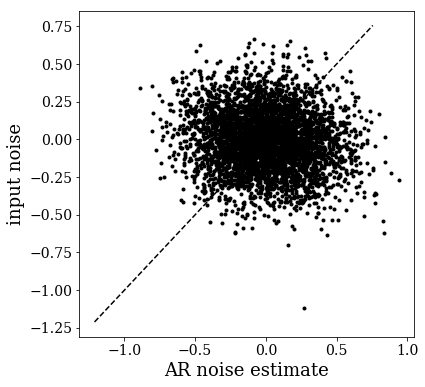

In [4]:

res_norm = res/sp.std(res)
F,(ax1,ax2) = plt.subplots(1,2)
N,bins,patches = ax1.hist(res_norm, len(res_norm)//100)
#fit a gaussian
x = sp.mean([bins[0:-1],bins[1:]], axis=0)
p,covar = fit_gaussian(x,N)
print(p)
plotx = sp.r_[min(x):max(x):100j]
ploty = p[2]*sp.exp(-0.5*(plotx - p[0])**2/p[1]**2)
ax1.plot(plotx,ploty,'r',lw=2)
#cumulative distribution

ax2.plot(x,sp.cumsum(N)/sp.sum(N),'b' )
lx,hx = ax2.get_xlim()
ly,hy = ax2.get_ylim()

ax2.plot([1.0,1.0],[ly,hy],'k--')
ax2.plot([-1.0,-1.0],[ly,hy],'k--')
ax2.plot([lx,hx],[0.16,0.16],'k--')
ax2.plot([lx,hx],[0.84,0.84],'k--')

ax2.set_ylim([ly,hy])
ax2.set_xlim([lx,hx])

ax1.set_xlabel('Standard Deviations')
ax2.set_xlabel('Standard Deviations')
ax2.set_ylabel('CDF')
F.set_size_inches(16,6)

F,(ax1) = plt.subplots(1,1)
print(sp.std(res),sp.std(noise[N_memory-1::]))
ax1.plot(res, noise[N_memory-1::],'k.')
ax1.set_xlabel('AR noise estimate')
ax1.set_ylabel('input noise')
l,h = ax1.get_ylim()
ax1.plot([l,h],[l,h],'k--')

F.set_size_inches(6,6)

It turns out that if we fit the original data, we get different coefficients.  But, the prediction is exactly the same.  That suggests to me some degeneracy in the model.  But, they both predict the data very well

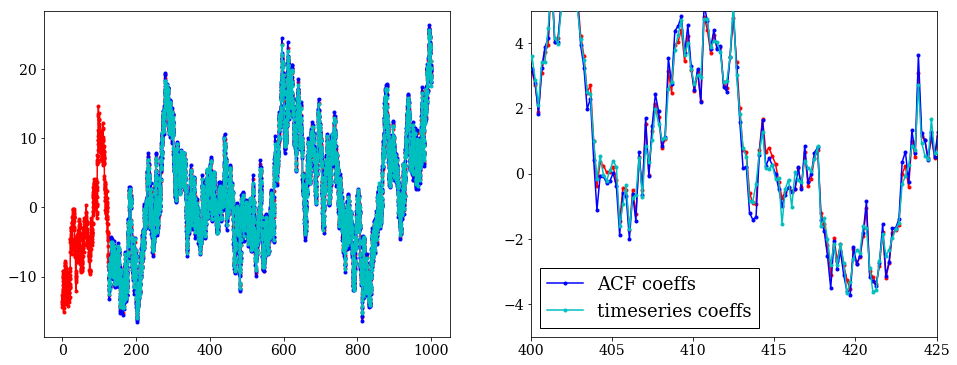

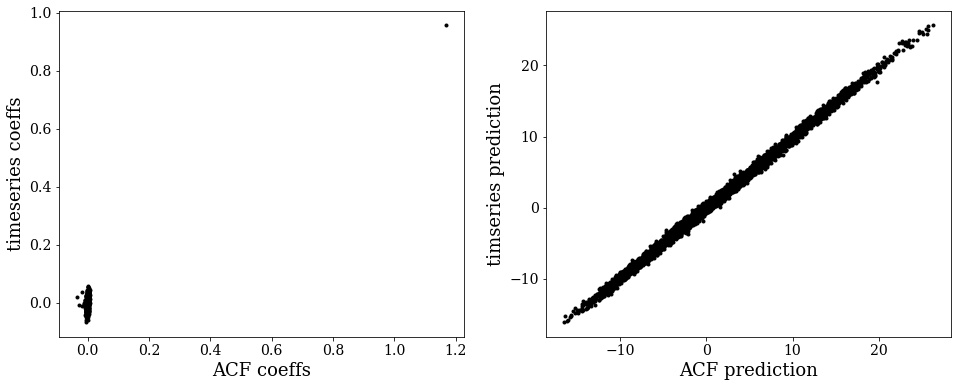

In [5]:
B2 = fit_coeffs(f,N_memory)
pred2 = sp.convolve(f,B2,'vaild')


F,( ax1,ax2) = plt.subplots(1,2)
ax1.plot(t,f,'r.-',label='flux')
ax1.plot(t[N_memory-1:] ,pred,'b.-',zorder=2)
ax1.plot(t[N_memory-1:] ,pred2,'c.-',zorder=3)

#zoom in 
ax2.plot(t,f,'r.-')
ax2.plot(t[N_memory-1:] ,pred,'b.-',zorder=2,label='ACF coeffs')
ax2.plot(t[N_memory-1:] ,pred2,'c.-',zorder=3,label='timeseries coeffs')

ax2.set_xlim([400,425])
ax2.set_ylim([-5,5])
ax2.legend()

F.set_size_inches(16,6)

F,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(B,B2,'k.')
ax1.set_xlabel('ACF coeffs')
ax1.set_ylabel('timeseries coeffs')
ax2.plot(pred,pred2,'k.')
ax2.set_xlabel('ACF prediction')
ax2.set_ylabel('timseries prediction')

F.set_size_inches(16,6)

AR models can be interprted as the result of an impulse response.  Let's look at that response!

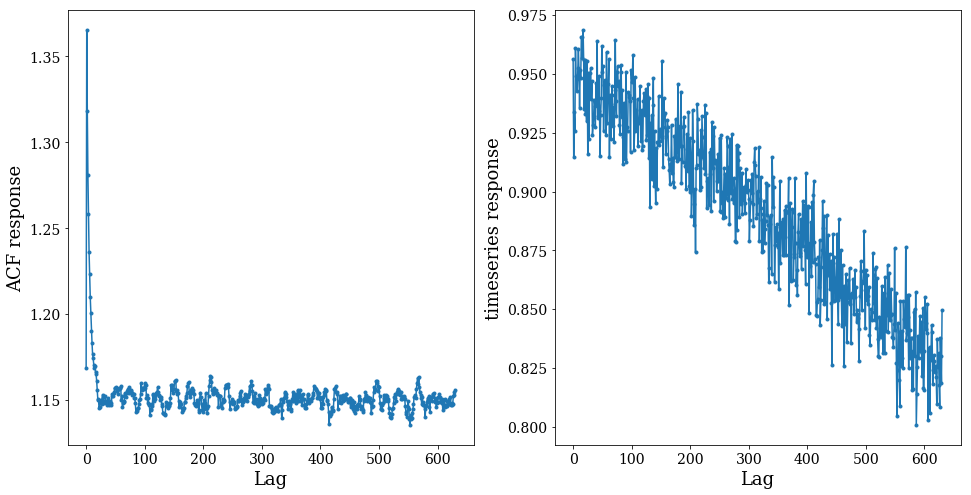

In [6]:
def get_response(coeffs):
    extrap = sp.zeros(len(coeffs))
    extrap[-1] = 1.0
    for ii in range(len(coeffs)):
        extrap[len(coeffs) -1 - ii] = sp.sum(extrap*coeffs[::-1])

    return extrap[::-1]

resp1 = get_response(B)
resp2 = get_response(B2)

F,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(resp1,'.-')
ax1.set_ylabel('ACF response')
ax1.set_xlabel('Lag')

ax2.plot(resp2,'.-')
ax2.set_ylabel('timeseries response')
ax2.set_xlabel('Lag')

F.set_size_inches(16,8)

And now, we see that the stastmodel AR class is fitting in the time domain.  The small differences may be due to either regularization in `statsmodels` (I don't know if they implemented any), or the minor "corruption" of wrap arround in the design matrices that I use.

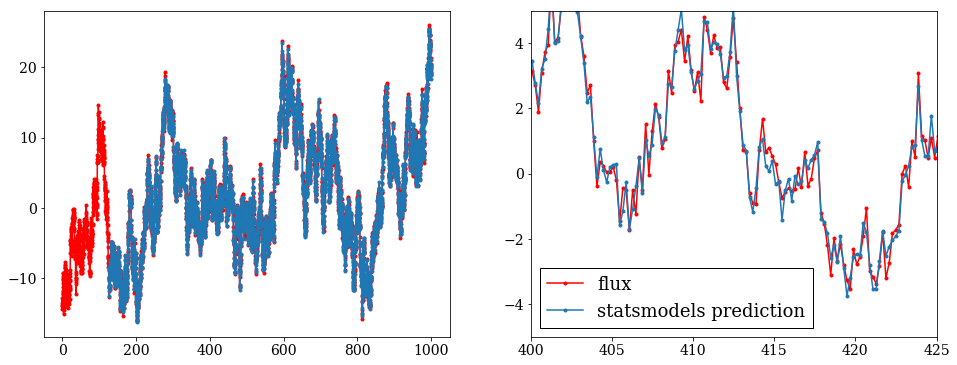

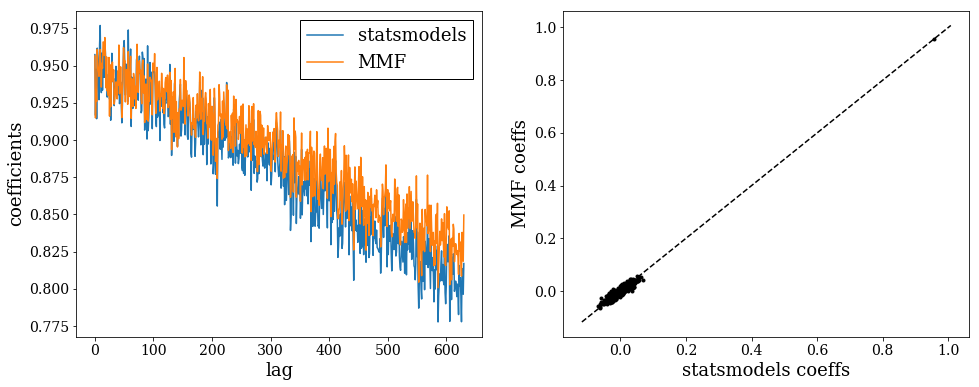

In [7]:
from statsmodels.tsa.ar_model import AR
mod = AR(f)
AR_result = mod.fit(maxlag=N_memory,trend='nc')
resp3 = get_response(AR_result.params)

F,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(t,f,'r.-')
ax1.plot(t[N_memory-1::], AR_result.predict(start=N_memory,end=len(t)),'.-',zorder=2)

ax2.plot(t,f,'r.-',label='flux')
ax2.plot(t[N_memory-1::], AR_result.predict(start=N_memory,end=len(t)),'.-',zorder=2,label='statsmodels prediction')
ax2.set_xlim([400,425])
ax2.set_ylim([-5,5])
ax2.legend()

F.set_size_inches(16,6)


F,(ax1,ax2) = plt.subplots(1,2)
ax1.plot(resp3,label='statsmodels')
ax1.plot(resp2,label='MMF')
ax1.set_xlabel('lag')
ax1.set_ylabel('coefficients')
ax1.legend()

ax2.plot(AR_result.params,B2,'k.')
ax2.set_xlabel('statsmodels coeffs')
ax2.set_ylabel('MMF coeffs')
l,h = ax2.get_ylim()
ax2.plot([l,h],[l,h],'k--')

F.set_size_inches(16,6)

Lastly, we'd like to compare predictions between these 3 models, extrapolating to times in the future.  Some observaitons

* All models are damped.
* The ACF based model damps a lot more slowly
* The fits to the timeseries are very similar, a result of the responses/coeffecients shown above.

1000.0


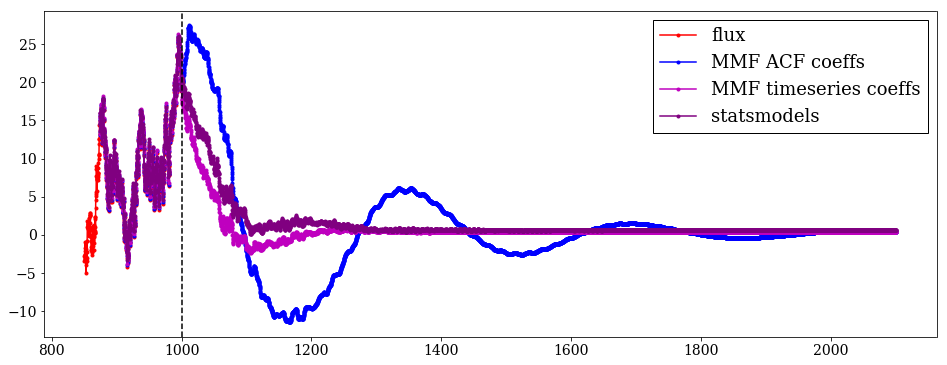

In [8]:
def extrapolate(y,npredict,coeffs):
    extrap = y[-len(coeffs):]
    for ii in range(npredict):
        extrap = sp.r_[extrap, sp.sum(extrap[-len(coeffs):]*coeffs[::-1]) ]
    return extrap


N_predict = 5500


dt = t[1] - t[0]

extrap1 = extrapolate(f,N_predict,B)
extrap2 = extrapolate(f,N_predict,B2)
extrap3 = AR_result.predict(start=len(t) - len(AR_result.params) + 1, end= len(t) + N_predict)

F,(ax1) = plt.subplots(1,1)
ax1.plot(t[-750:],f[-750:],'r.-',label='flux')

plot_t = dt*sp.r_[0:N_predict + len(B)] + t[-len(B)]

ax1.plot(plot_t, extrap1+0.2,'b.-',label='MMF ACF coeffs')
ax1.plot(plot_t, extrap2+0.4,'m.-',label='MMF timeseries coeffs')
ax1.plot(plot_t, extrap3+0.6,'.-',color='purple',label='statsmodels')

l,h = ax1.get_ylim()
ax1.plot([t[-1],t[-1]],[l,h],'k--')
ax1.set_ylim([l,h])
print(t[-1])
#ax1.set_xlim([950,1025])
#ax1.set_xlim([1700,2000])
#ax1.set_ylim([-1.0, 1.0])
ax1.legend()

F.set_size_inches(16,6)


(400, 425)

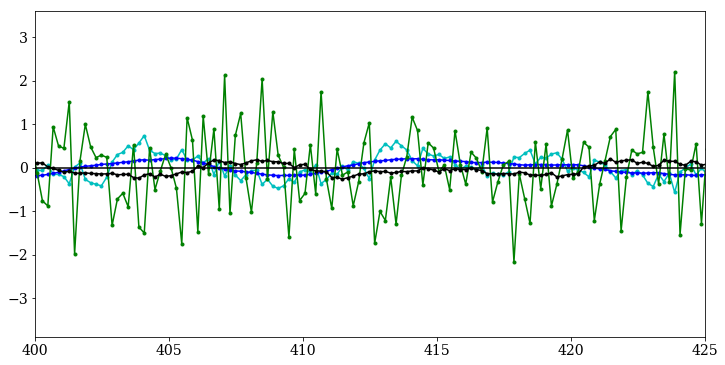

In [9]:
d1 = f[N_memory:] - AR_result.fittedvalues
d2 = f[N_memory-1:] - sp.convolve(f,B,'valid')
d3 = f[N_memory-1:] - sp.convolve(f,B2,'valid')
F,(ax1) = plt.subplots(1,1)
#ax1.plot(t[N_memory-1:],d2,'b.-')
#ax1.plot(t[N_memory-1:],d3,'r.-')
w = sp.ones(25)
w = w/sp.sum(w)
#ax1.plot(t[N_memory-1:],d3,'r.-')
#ax1.plot(t[N_memory-1:],sp.convolve(d3,w,'same'),'m.-')

ax1.plot(t[N_memory-1:],d2,'c.-')
ax1.plot(t[N_memory-1:],sp.convolve(d2,w,'same'),'b.-')


ax1.plot(t[N_memory:],d1,'.-',color='g')
ax1.plot(t[N_memory:],sp.convolve(d1,w,'same'),'k.-')
#confirmthat the model resid matches this one
#ax1.plot(AR_result.resid+0.2,'.-')
ax1.plot(sp.zeros(len(f[N_memory:])),'k')
ax1.set_xlim([400,425])